In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('coffee_orders.csv',  encoding = "latin1")
df.head()

,Order ID,Customer ID,Location ID,Time of purchase,PreTax Total,Customer Order,Quantity
0,4799,9268,102,2024-11-04 11:02:00,4.94,Pistachio Frappe Latte:1:4.94,1
1,9567,5406,102,2024-11-01 18:04:54,7.84,Latte:2:3.92,2
2,8201,5406,104,2024-11-07 18:27:07,4.18,Cappuccino:1:4.18,1
3,3920,3424,101,2024-11-03 00:54:35,27.35,Butter Croissant:5:5.47,5
4,6850,6632,103,2024-11-05 03:00:48,2.62,Sausage & Cheddar Frittata:1:2.62,1


In [3]:
# Assuming 'Order Date' is the column with datetime information
df['Time of purchase'] = pd.to_datetime(df['Time of purchase'])  # Ensure it's in datetime format

# Create 'Hour' column (extract hour from the datetime)
df['Hour'] = df['Time of purchase'].dt.hour

# Create 'Day_of_week' column (extract day of the week as a number, Monday=0, Sunday=6)
df['Day_of_week'] = df['Time of purchase'].dt.dayofweek

# Now group by Customer ID and aggregate
aggregated_df = df.groupby('Customer ID').agg({
    'Order ID': 'count',  # Number of orders for the customer
    'PreTax Total': 'sum',  # Sum up the total spent
    'Quantity': 'sum',  # Total quantity of items
    'Hour': 'mean',  # Average time of purchase (hour of the day)
    'Day_of_week': lambda x: list(set(x)),  # Unique days the customer visited
    'Customer Order': lambda x: '; '.join(x)  # Combine all orders into a single string
}).reset_index()

# Rename columns for clarity
aggregated_df = aggregated_df.rename(columns={
    'Order ID': 'Total_Orders',
    'PreTax Total': 'Total_Spent',
    'Quantity': 'Total_Quantity',
    'Day_of_week': 'Unique_Visit_Days',
    'Customer Order': 'All_Orders'
})

# Display the resulting dataset
aggregated_df.head()


,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders
0,1001,2,14.85,3,8.0,"[3, 5]",Iced Latte:1:3.25; Hot Tea:2:5.8
1,1002,1,3.14,1,13.0,[0],White Chocolate Mocha:1:3.14
2,1005,1,7.28,2,13.0,[3],Vegan Breakfast Roll:2:3.64
3,1008,1,9.10,2,18.0,[1],Latte:1:3.92;Caramel Apple Yogurt:1:5.18
4,1014,1,4.18,1,2.0,[2],Cappuccino:1:4.18


In [4]:
import pandas as pd

# Assuming 'aggregated_df' is the existing DataFrame
aggregated_df['Avg_Items_Per_Order'] = aggregated_df['Total_Quantity'] / aggregated_df['Total_Orders']
# Initialize a dictionary to track mean values for customers
mean_values = {
    'Total_Spent': aggregated_df['Total_Spent'].mean(),
    'Unique_Visit_Days': aggregated_df['Unique_Visit_Days'].apply(lambda x: len(set(x))).mean()  # mean of the count of unique visit days
}

def label_customer(row):
    # Get current mean values for comparison
    mean_items_per_order = mean_values['Total_Spent']
    mean_visit_days = mean_values['Unique_Visit_Days']
    
    # Label based on visit frequency compared to the mean
    # A customer is a regular if they have unique visit days greater than or equal to the mean
    unique_visit_count = len(set(row['Unique_Visit_Days']))  # Number of unique visit days
    if unique_visit_count >= mean_visit_days:
        visit_label = 'Regular Customer'
    else:
        visit_label = 'Non-Regular Customer'
    
    # Label based on items per order compared to the mean
    # A customer is a high spender if their average items per order is greater than or equal to the mean
    if row['Total_Spent'] >= mean_items_per_order:
        spend_label = 'High Spend Customer'
    else:
        spend_label = 'Low Spend Customer'
    
    # Update the running means (assuming row is for a customer)
    mean_values['Total_Spent'] = (mean_values['Total_Spent'] * len(aggregated_df) + row['Total_Spent']) / (len(aggregated_df) + 1)
    mean_values['Unique_Visit_Days'] = (mean_values['Unique_Visit_Days'] * len(aggregated_df) + unique_visit_count) / (len(aggregated_df) + 1)
    
    return f'{visit_label} - {spend_label}'

# Apply the labeling function to the dataset
aggregated_df['Customer_Label'] = aggregated_df.apply(label_customer, axis=1)


In [5]:
aggregated_df['Customer_Label'] = aggregated_df.apply(label_customer, axis=1)

# Display the resulting labels
aggregated_df[['Customer ID', 'Customer_Label']].head()
aggregated_df

,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders,Avg_Items_Per_Order,Customer_Label
0,1001,2,14.85,3,8.0,"[3, 5]",Iced Latte:1:3.25; Hot Tea:2:5.8,1.5,Regular Customer - High Spend Customer
1,1002,1,3.14,1,13.0,[0],White Chocolate Mocha:1:3.14,1.0,Non-Regular Customer - Low Spend Customer
2,1005,1,7.28,2,13.0,[3],Vegan Breakfast Roll:2:3.64,2.0,Non-Regular Customer - Low Spend Customer
3,1008,1,9.10,2,18.0,[1],Latte:1:3.92;Caramel Apple Yogurt:1:5.18,2.0,Non-Regular Customer - Low Spend Customer
4,1014,1,4.18,1,2.0,[2],Cappuccino:1:4.18,1.0,Non-Regular Customer - Low Spend Customer
...,...,...,...,...,...,...,...,...,...
3719,9983,1,3.25,1,7.0,[6],Iced Latte:1:3.25,1.0,Non-Regular Customer - Low Spend Customer
3720,9989,1,4.45,1,14.0,[1],Café au Lait:1:4.45,1.0,Non-Regular Customer - Low Spend Customer
3721,9993,1,10.84,4,18.0,[0],Roasted Tomato Breakfast Roll:4:2.71,4.0,Non-Regular Customer - High Spend Customer
3722,9994,1,11.60,2,10.0,[5],Hot Tea:2:5.8,2.0,Non-Regular Customer - High Spend Customer


# Features Engineering


In [6]:
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']]
labels = aggregated_df['Customer_Label']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
x_Train, x_Test, y_Train, y_Test = train_test_split(scaled_features, labels, test_size = 0.2 , random_state=42)


In [7]:
import pandas as pd
import numpy as np

# Example: Split combined labels and create binary features
# Assuming 'Customer_Label' is a column with combined labels
def split_labels(labels):
    return labels.split(' - ') if isinstance(labels, str) else []

# Apply the split function to create a list of labels for each customer
aggregated_df['Label_List'] = aggregated_df['Customer_Label'].apply(split_labels)

# Now we create binary features for each possible label
all_labels = set(label for label_list in aggregated_df['Label_List'] for label in label_list)
label_map = {label: i for i, label in enumerate(all_labels)}

# Create binary columns for each label
for label in all_labels:
    aggregated_df[label] = aggregated_df['Label_List'].apply(lambda x: 1 if label in x else 0)

# Check the resulting datafr
aggregated_df.head()

# Now you can proceed to use these labels in your clustering or KNN model


,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders,Avg_Items_Per_Order,Customer_Label,Label_List,Non-Regular Customer,Low Spend Customer,Regular Customer,High Spend Customer
0,1001,2,14.85,3,8.0,"[3, 5]",Iced Latte:1:3.25; Hot Tea:2:5.8,1.5,Regular Customer - High Spend Customer,"[Regular Customer, High Spend Customer]",0,0,1,1
1,1002,1,3.14,1,13.0,[0],White Chocolate Mocha:1:3.14,1.0,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",1,1,0,0
2,1005,1,7.28,2,13.0,[3],Vegan Breakfast Roll:2:3.64,2.0,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",1,1,0,0
3,1008,1,9.10,2,18.0,[1],Latte:1:3.92;Caramel Apple Yogurt:1:5.18,2.0,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",1,1,0,0
4,1014,1,4.18,1,2.0,[2],Cappuccino:1:4.18,1.0,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",1,1,0,0


In [8]:
# Initialize knn model
import joblib
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_Train, y_Train)

y_pred = knn.predict(x_Test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_Test, y_pred)
print(f"Accuracy of KNN model: {accuracy * 100:.2f}%")
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
feature_order = aggregated_df.columns.tolist()
with open('feature_order.txt', 'w') as f:
    for feature in feature_order:
        f.write(f"{feature}\n")


Accuracy of KNN model: 95.17%


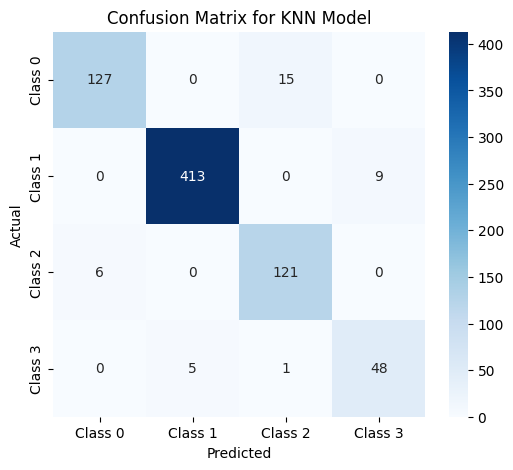

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_Test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [12]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the trained KNN model and the scaler
knn = joblib.load('knn_model.pkl')  # Load the trained KNN model
scaler = joblib.load('scaler.pkl')  # Load the StandardScaler that was used during training

# Define new customer data (example)
new_customer_data = pd.DataFrame([{
    'Total_Orders': 4,
    'Total_Spent': 5.00,
    'Total_Quantity': 2,
    'Avg_Items_Per_Order':5  # 5 items ordered in 3 orders
}])

# Define the feature order (same order as was used during training)
feature_order = ['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']
new_customer_data = new_customer_data[feature_order]

# Ensure the data is scaled using the same scaler
new_customer_data_scaled = scaler.transform(new_customer_data)

# Predict the label for the new customer using the trained KNN model
prediction = knn.predict(new_customer_data_scaled)

# Print the predicted label
print(f"Predicted Label for the New Customer: {prediction[0]}")


Predicted Label for the New Customer: Regular Customer - High Spend Customer


In [11]:
# Group the DataFrame by the customer label
grouped = aggregated_df.groupby('Customer_Label')[['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']].mean()

grouped


,Total_Orders,Total_Spent,Total_Quantity,Avg_Items_Per_Order
Customer_Label,,,,
Non-Regular Customer - High Spend Customer,1.104499,18.029681,4.227866,3.957910
Non-Regular Customer - Low Spend Customer,1.020520,4.801537,1.220246,1.198814
Regular Customer - High Spend Customer,2.539792,22.213478,5.346021,2.173356
Regular Customer - Low Spend Customer,2.018939,7.851818,2.087121,1.034091


In [21]:
import plotly.express as px
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the trained KNN model and scaler
knn = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')

# Assuming 'aggregated_df' is the DataFrame that contains the customer data
# Example customer features
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']]

# Scale the features using the loaded scaler
scaled_features = scaler.transform(features)

# Use the trained KNN model to predict the cluster for each customer
predicted_clusters = knn.predict(scaled_features)

# Add the predicted cluster to the DataFrame for plotting
aggregated_df['Cluster'] = predicted_clusters

# Map clusters to numeric values for color-coding
aggregated_df['Cluster_numeric'] = pd.Categorical(aggregated_df['Cluster']).codes

# Add the customer ID and labels as hover data
aggregated_df['Hover_data'] = aggregated_df['Total_Orders'].astype(str) + '<br>' + aggregated_df['Total_Spent'].astype(str) + '<br>' + aggregated_df['Cluster']

# Create a plotly scatter plot with hover data
fig = px.scatter(aggregated_df, 
                 x='Total_Orders', 
                 y='Total_Spent', 
                 color='Cluster_numeric', 
                 hover_data={'Cluster': True, 'Total_Orders': True, 'Total_Spent': True},
                 title="Customer Clusters",
                 labels={'Total_Orders': 'Total Orders', 'Total_Spent': 'Total Spent'},
                 color_continuous_scale='viridis')

# Show the plot
fig.show()


In [23]:
import plotly.express as px
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the trained KNN model and scaler
knn = joblib.load('knn_model.pkl')
scaler = joblib.load('scaler.pkl')

# Assuming 'aggregated_df' is the DataFrame that contains the customer data
# Example customer features
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']]

# Scale the features using the loaded scaler
scaled_features = scaler.transform(features)

# Use the trained KNN model to predict the cluster for each customer
predicted_clusters = knn.predict(scaled_features)

# Add the predicted cluster to the DataFrame for plotting
aggregated_df['Cluster'] = predicted_clusters

# Map clusters to numeric values for color-coding
aggregated_df['Cluster_numeric'] = pd.Categorical(aggregated_df['Cluster']).codes

# Plot using Plotly
fig = px.scatter(aggregated_df, x='Total_Orders', y='Total_Spent', color='Cluster',
                 hover_data={'Cluster': True, 'Total_Orders': True, 'Total_Spent': True, 'Avg_Items_Per_Order': True},
                 title='Customer Clusters based on Total Orders and Total Spent')

# Show the plot
fig.show()
